In [ ]:
from google.colab import files
import os

# Upload your local CMAPSS files manually
uploaded = files.upload()  # choose train_FD001.txt, test_FD001.txt, RUL_FD001.txt

# Create /data folder and move files there if needed
os.makedirs("data", exist_ok=True)

for name in uploaded.keys():
    if not os.path.exists(os.path.join("data", name)):
        os.rename(name, os.path.join("data", name))

print("✅ Uploaded files:", os.listdir("data"))


KeyboardInterrupt: 

In [ ]:
!pip install transformers datasets tokenizers

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def pick_nonempty(name):
    candidates = [os.path.join("data", name), name]  # prefer data/, then root
    for p in candidates:
        if os.path.exists(p) and os.path.getsize(p) > 0:
            return p
    raise FileNotFoundError(f"Could not find a non-empty file for {name} in data/ or project root.")

train_path = pick_nonempty("train_FD001.txt")
test_path  = pick_nonempty("test_FD001.txt")
rul_path   = pick_nonempty("RUL_FD001.txt")

print("Using:", train_path, test_path, rul_path)

columns = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i:02d}' for i in range(1, 22)]

# Use raw regex to split on whitespace
train_df = pd.read_csv(train_path, sep=r'\s+', header=None, names=columns)
test_df  = pd.read_csv(test_path,  sep=r'\s+', header=None, names=columns)
rul_test = pd.read_csv(rul_path,   header=None, names=['RUL'])

print("Shapes:", train_df.shape, test_df.shape, rul_test.shape)  # sanity check

# Add RUL to train
train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)
train_df['RUL_clipped'] = np.minimum(train_df['RUL'], 125)

# Normalize sensor columns
sensor_cols = [f'sensor{i:02d}' for i in range(1, 22)]
scaler = StandardScaler()
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])
test_df[sensor_cols]  = scaler.transform(test_df[sensor_cols])

train_df.head()

Using: train_FD001.txt test_FD001.txt RUL_FD001.txt
Shapes: (20631, 26) (13096, 26) (100, 1)


,engine_id,cycle,setting1,setting2,setting3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL,RUL_clipped
0,1,1,-0.0007,-0.0004,100.0,0.0,-1.721725,-0.134255,-0.925936,-1.776357e-15,...,-0.269071,-0.603816,-1.387779e-17,-0.781710,0.0,0.0,1.348493,1.194427,191,125
1,1,2,0.0019,-0.0003,100.0,0.0,-1.061780,0.211528,-0.643726,-1.776357e-15,...,-0.642845,-0.275852,-1.387779e-17,-0.781710,0.0,0.0,1.016528,1.236922,190,125
2,1,3,-0.0043,0.0003,100.0,0.0,-0.661813,-0.413166,-0.525953,-1.776357e-15,...,-0.551629,-0.649144,-1.387779e-17,-2.073094,0.0,0.0,0.739891,0.503423,189,125
3,1,4,0.0007,0.0000,100.0,0.0,-0.661813,-1.261314,-0.784831,-1.776357e-15,...,-0.520176,-1.971665,-1.387779e-17,-0.781710,0.0,0.0,0.352598,0.777792,188,125
4,1,5,-0.0019,-0.0002,100.0,0.0,-0.621816,-1.251528,-0.301518,-1.776357e-15,...,-0.521748,-0.339845,-1.387779e-17,-0.136018,0.0,0.0,0.463253,1.059552,187,125


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


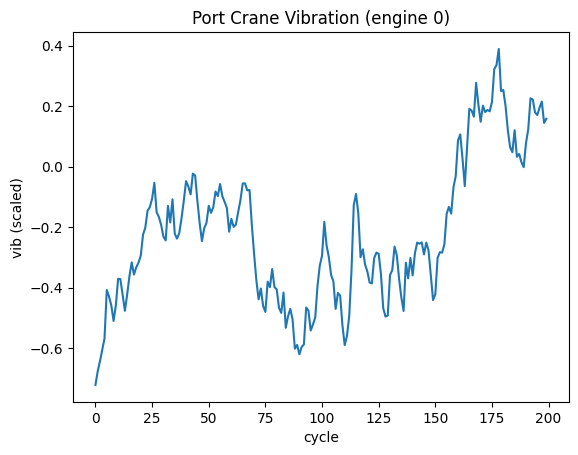

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ---------- helpers ----------

def _alloc_lengths(n_entities, total_rows, lo, hi, rng):
    """Allocate per-entity lengths so sum ≈ total_rows within [lo, hi]."""
    lens = rng.integers(lo, hi + 1, size=n_entities)
    scale = total_rows / max(1, lens.sum())
    lens = np.maximum(lo, np.minimum(hi, np.round(lens * scale).astype(int)))
    # ensure at least 1 step
    lens = np.maximum(1, lens)
    return lens

def _rul_linear(n):
    """RUL that decreases linearly to 0 at the last cycle (inclusive)."""
    # If n==1, RUL is 0
    if n <= 1:
        return np.array([0.0])
    return np.linspace(n - 1, 0, n, dtype=float)

# ---------- Port (cranes: vib, temp, load, wind) ----------

def generate_port_data(n_samples=10_000, n_engines=50,
                       min_cycles=200, max_cycles=800, seed=42,
                       scale_now=True, scaler=None):
    rng = np.random.default_rng(seed)
    lens = _alloc_lengths(n_engines, n_samples, min_cycles, max_cycles, rng)

    frames = []
    for eng, n in enumerate(lens):
        cycles = np.arange(n)
        vib = np.cumsum(rng.normal(0, 0.1, n)) + np.linspace(0, 2, n)
        temp = 20 + 0.5 * vib + rng.normal(0, 2, n)
        load = rng.uniform(0.5, 1.5, n)
        wind = rng.normal(5, 3, n)
        rul = _rul_linear(n)
        frames.append(pd.DataFrame({
            "engine_id": eng, "cycle": cycles,
            "vib": vib, "temp": temp, "load": load, "wind": wind,
            "RUL": rul, "RUL_clipped": np.minimum(rul, 125)
        }))

    df = pd.concat(frames, ignore_index=True)

    if scale_now:
        scaler = scaler or StandardScaler()
        cols = ["vib", "temp", "load", "wind"]
        df[cols] = scaler.fit_transform(df[cols])
        return df, scaler
    return df, None

# ---------- Fleet (trucks: speed, fuel, rpm, tire_press) ----------

def generate_fleet_data(n_samples=8_000, n_vehicles=30,
                        min_cycles=150, max_cycles=600, seed=43,
                        scale_now=True, scaler=None):
    rng = np.random.default_rng(seed)
    lens = _alloc_lengths(n_vehicles, n_samples, min_cycles, max_cycles, rng)

    frames = []
    for veh, n in enumerate(lens):
        cycles = np.arange(n)
        speed = np.clip(np.cumsum(rng.normal(0, 5, n)) + 60, 0, 120)
        fuel = 100 - 0.3 * np.arange(n) + rng.normal(0, 5, n)
        rpm = 2000 + 10 * speed + rng.normal(0, 100, n)
        tire_press = np.full(n, 32.0) + np.linspace(0, -5, n)
        rul = _rul_linear(n)
        frames.append(pd.DataFrame({
            "vehicle_id": veh, "cycle": cycles,
            "speed": speed, "fuel": fuel, "rpm": rpm, "tire_press": tire_press,
            "RUL": rul, "RUL_clipped": np.minimum(rul, 125)
        }))

    df = pd.concat(frames, ignore_index=True)

    if scale_now:
        scaler = scaler or StandardScaler()
        cols = ["speed", "fuel", "rpm", "tire_press"]
        df[cols] = scaler.fit_transform(df[cols])
        return df, scaler
    return df, None

# ---------- Factory (machines: torque, current, humidity, power) ----------

def generate_factory_data(n_samples=12_000, n_machines=40,
                          min_cycles=300, max_cycles=1000, seed=44,
                          scale_now=True, scaler=None):
    rng = np.random.default_rng(seed)
    lens = _alloc_lengths(n_machines, n_samples, min_cycles, max_cycles, rng)

    frames = []
    for m, n in enumerate(lens):
        cycles = np.arange(n)
        torque = np.cumsum(rng.normal(0, 0.05, n)) + np.linspace(0, 1.5, n)
        current = 10 + 0.2 * torque + rng.normal(0, 1, n)
        humidity = rng.uniform(40, 60, n)
        power = current * rng.uniform(220, 240, n)
        rul = _rul_linear(n)
        frames.append(pd.DataFrame({
            "machine_id": m, "cycle": cycles,
            "torque": torque, "current": current, "humidity": humidity, "power": power,
            "RUL": rul, "RUL_clipped": np.minimum(rul, 125)
        }))

    df = pd.concat(frames, ignore_index=True)

    if scale_now:
        scaler = scaler or StandardScaler()
        cols = ["torque", "current", "humidity", "power"]
        df[cols] = scaler.fit_transform(df[cols])
        return df, scaler
    return df, None

# ---------- generate ----------

port_df, port_scaler = generate_port_data()
fleet_df, fleet_scaler = generate_fleet_data()
factory_df, factory_scaler = generate_factory_data()

# ---------- example plot ----------
m = port_df["engine_id"] == 0
plt.plot(port_df.loc[m, "cycle"], port_df.loc[m, "vib"])
plt.title("Port Crane Vibration (engine 0)")
plt.xlabel("cycle"); plt.ylabel("vib (scaled)")
plt.show()


In [ ]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler

# ---------- modalities ----------

def generate_audio_modality(df, sensor_col='sensor02', sr=22050, duration=1.0, n_mfcc=13):
    """MFCC features per row using a sensor as a decay proxy."""
    n = len(df)
    t = np.linspace(0.0, duration, int(sr * duration), dtype=np.float32)
    base = np.sin(2 * np.pi * 440.0 * t).astype(np.float32)  # shared sine
    out = np.empty((n, n_mfcc), dtype=np.float32)
    vals = df[sensor_col].to_numpy(dtype=np.float32)
    for i, v in enumerate(vals):
        audio = base * np.exp(-v * t)  # simple decay by sensor value
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, center=False).mean(axis=1)
        out[i] = mfcc.astype(np.float32)
    return out

def generate_image_modality(df, sensor_col='sensor03'):
    """Mock 10x10 thermal: diagonal boosted by sensor value."""
    n = len(df)
    eye = np.eye(10, dtype=np.float32)
    out = np.empty((n, 100), dtype=np.float32)
    vals = df[sensor_col].to_numpy(dtype=np.float32)
    for i, v in enumerate(vals):
        img = np.random.normal(30.0, 5.0, (10, 10)).astype(np.float32) + v * eye
        out[i] = img.ravel()
    return out

# ---------- sequence builder (per entity) ----------

def create_sequences_by_entity(X, y, ids, seq_length):
    """
    Create sliding windows without crossing entity boundaries.
    X: (N, F), y: (N,), ids: (N,)
    Returns: X_seq (M, seq_length, F), y_seq (M,)
    """
    X_seq, y_seq = [], []
    # find segment boundaries where id changes
    boundaries = np.where(np.diff(ids) != 0)[0] + 1
    starts = np.concatenate(([0], boundaries))
    ends   = np.concatenate((boundaries, [len(ids)]))

    for s, e in zip(starts, ends):
        seg_X = X[s:e]
        seg_y = y[s:e]
        if len(seg_X) <= seq_length:
            continue
        for i in range(seq_length, len(seg_X)):
            X_seq.append(seg_X[i-seq_length:i])
            y_seq.append(seg_y[i])
    return np.asarray(X_seq), np.asarray(y_seq)

# ---------- fuse + window (subset for speed) ----------

subset_size = 5000
df_sub = train_df.head(subset_size).copy()

audio_feat  = generate_audio_modality(df_sub, sensor_col='sensor02', sr=22050, duration=1.0)
image_feat  = generate_image_modality(df_sub, sensor_col='sensor03')
sensor_feat = df_sub[sensor_cols].to_numpy(dtype=np.float32)

# concatenate -> (N, 21 + 13 + 100) = (N, 134)
fused_X = np.concatenate([sensor_feat, audio_feat, image_feat], axis=1).astype(np.float32)
fused_y = df_sub['RUL_clipped'].to_numpy(dtype=np.float32)
fused_ids = df_sub['engine_id'].to_numpy()

# scale fused features BEFORE windowing
fused_scaler = StandardScaler()
fused_X = fused_scaler.fit_transform(fused_X).astype(np.float32)

seq_length = 30
X_fused, y_fused = create_sequences_by_entity(fused_X, fused_y, fused_ids, seq_length=seq_length)
print("X_fused shape:", X_fused.shape)  # e.g., (M, 30, 134)
print("y_fused shape:", y_fused.shape)


X_fused shape: (4250, 30, 134)
y_fused shape: (4250,)


In [ ]:
!pip install -q tensorflow

Train: (2825, 30, 141), Val: (575, 30, 141)
Epoch 1/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 70.9067 - mae: 71.4039 - val_loss: 21.7541 - val_mae: 22.2478 - learning_rate: 0.0010
Epoch 2/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 14.7562 - mae: 15.2461 - val_loss: 12.8141 - val_mae: 13.3108 - learning_rate: 0.0010
Epoch 3/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.9967 - mae: 8.4780 - val_loss: 11.2386 - val_mae: 11.7151 - learning_rate: 0.0010
Epoch 4/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.6383 - mae: 6.1168 - val_loss: 13.3128 - val_mae: 13.7931 - learning_rate: 0.0010
Epoch 5/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.0149 - mae: 5.4937 - val_loss: 11.5805 - val_mae: 12.0692 - learning_rate: 0.0010
Epoch 6/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.5381 - mae: 5.0105 - val_loss: 11.7390 - val_mae: 12.2272 - learning_rate: 0.0010
Epoch 7/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.7129 - mae: 5.1903 - val_loss: 12

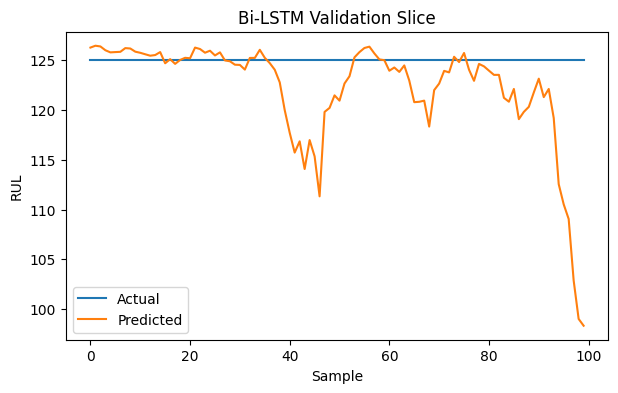

Running lightweight SHAP...


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.487e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.651e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.024e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 8

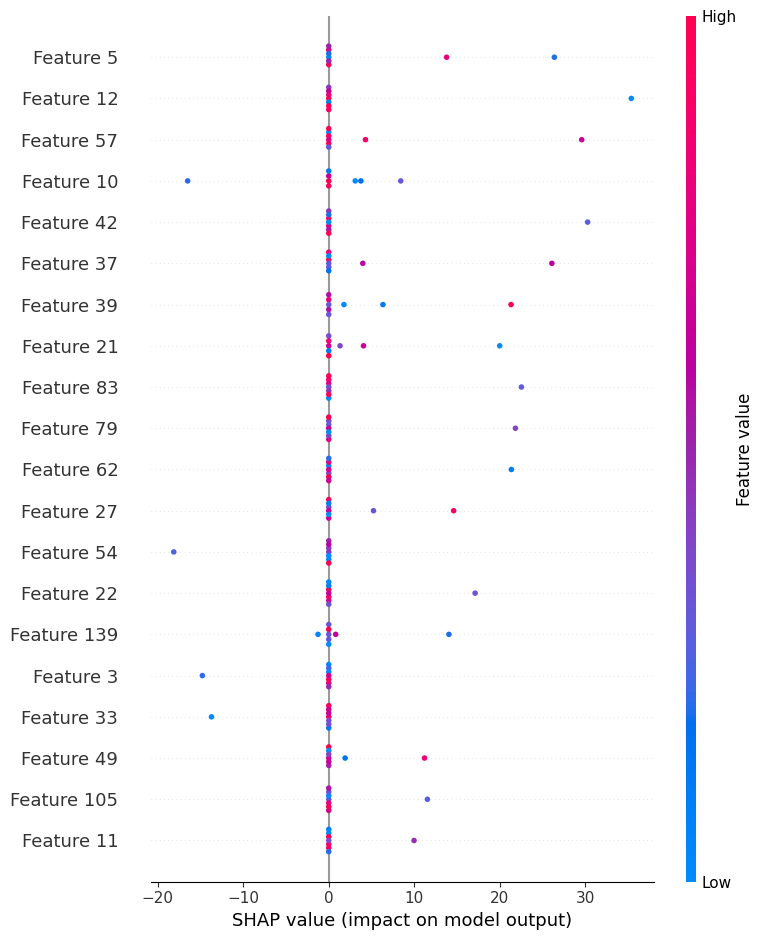

🔄 Attempting TFLite export...
Saved artifact at '/tmp/tmp1gfwld1v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 141), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134544256363664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256357904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256367120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256362128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256364624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256365392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256367888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256363088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256355216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256365008: TensorSpec(shape=(), dtype=tf.resource,

ConverterError: Could not translate MLIR to FlatBuffer.<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_2_1/backward_lstm_2_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_2_1/backward_lstm_2_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x141xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<138752xf32>, tensor<?xi32>) -> (tensor<?x30x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_2_1/backward_lstm_2_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_2_1/forward_lstm_2_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_2_1/forward_lstm_2_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x141xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<138752xf32>, tensor<?xi32>) -> (tensor<?x30x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_2_1/forward_lstm_2_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_3_1/backward_lstm_3_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_3_1/backward_lstm_3_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x30x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_3_1/backward_lstm_3_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_3_1/forward_lstm_3_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_3_1/forward_lstm_3_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x30x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_1_1/bidirectional_3_1/forward_lstm_3_1/CudnnRNNV3@__inference_function_22123"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_22206"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops in the model are custom ops, See instructions to implement custom ops: https://www.tensorflow.org/lite/guide/ops_custom 
Custom ops: CudnnRNNV3
Details:
	tf.CudnnRNNV3(tensor<?x30x141xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<138752xf32>, tensor<?xi32>) -> (tensor<?x30x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}
	tf.CudnnRNNV3(tensor<?x30x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x30x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}

<unknown>:0: note: see current operation: 
"func.func"() <{arg_attrs = [{tf_saved_model.index_path = ["keras_tensor_8"]}], function_type = (tensor<?x30x141xf32>) -> tensor<?x1xf32>, res_attrs = [{tf_saved_model.index_path = ["output_0"]}], sym_name = "main"}> ({
^bb0(%arg0: tensor<?x30x141xf32>):
  %0 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<82432xf32>}> : () -> tensor<82432xf32>
  %1 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<82432xf32>}> : () -> tensor<82432xf32>
  %2 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<138752xf32>}> : () -> tensor<138752xf32>
  %3 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<138752xf32>}> : () -> tensor<138752xf32>
  %4 = "arith.constant"() <{value = dense<64> : tensor<i32>}> : () -> tensor<i32>
  %5 = "arith.constant"() <{value = dense<128> : tensor<i32>}> : () -> tensor<i32>
  %6 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<f32>}> : () -> tensor<f32>
  %7 = "arith.constant"() <{value = dense<0> : tensor<1xi32>}> : () -> tensor<1xi32>
  %8 = "arith.constant"() <{value = dense<1> : tensor<i32>}> : () -> tensor<i32>
  %9 = "arith.constant"() <{value = dense<1> : tensor<1xi32>}> : () -> tensor<1xi32>
  %10 = "arith.constant"() <{value = dense<30> : tensor<i32>}> : () -> tensor<i32>
  %11 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<64xf32>}> : () -> tensor<64xf32>
  %12 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<32xf32>}> : () -> tensor<32xf32>
  %13 = "arith.constant"() <{value = dense<0.0529372431> : tensor<1xf32>}> : () -> tensor<1xf32>
  %14 = "arith.constant"() <{value = dense<[-1, 64]> : tensor<2xi32>}> : () -> tensor<2xi32>
  %15 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<1x32xf32>}> : () -> tensor<1x32xf32>
  %16 = "tfl.pseudo_qconst"() <{qtype = tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0021029957166806921,0.0023703169165633794,0.0022991550719644142,0.0024097606422394278,0.0019579486349436243,0.0021307299456258459,0.0022727319105403628,0.0020377075108956163,0.0023414853989608643,0.002410428730521615,0.0024486024548688273,0.0024219544853751117,0.0021891317029637614,0.0024718787726454848,0.00211604983787837,0.0023208138510936826,0.0019764442612805705,0.0020575232393159641,0.0024010710359558345,0.0023988743466655102,0.002101309890822163,0.0021825827012850545,0.0024402451327466589,0.0021807987858929972,0.0020793488645178128,0.0024322886166610116,0.0021220865681415469,0.0024216808672026385,0.0021487774811391755,0.0019910581937925085,0.0024794466852203129,0.0024745497177904984}>>, value = dense_resource<__elided__> : tensor<32x64xi8>}> : () -> tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0021029957166806921,0.0023703169165633794,0.0022991550719644142,0.0024097606422394278,0.0019579486349436243,0.0021307299456258459,0.0022727319105403628,0.0020377075108956163,0.0023414853989608643,0.002410428730521615,0.0024486024548688273,0.0024219544853751117,0.0021891317029637614,0.0024718787726454848,0.00211604983787837,0.0023208138510936826,0.0019764442612805705,0.0020575232393159641,0.0024010710359558345,0.0023988743466655102,0.002101309890822163,0.0021825827012850545,0.0024402451327466589,0.0021807987858929972,0.0020793488645178128,0.0024322886166610116,0.0021220865681415469,0.0024216808672026385,0.0021487774811391755,0.0019910581937925085,0.0024794466852203129,0.0024745497177904984}>>
  %17 = "tfl.pseudo_qconst"() <{qtype = tensor<64x128x!quant.uniform<i8<-127:127>:f32:0, {0.0018118658638375952,0.0018930736723847276,0.0016636325149085578,0.0016646089516286775,0.0016442470428511852,0.0018058281949185949,0.001877006465994467,0.0017574681775776419,0.0018828804568042905,0.0015310689689606194,0.0018179346257307398,0.0018530831796916452,0.0018514138976420005,0.0018125473279652633,0.0018686764822231504,0.0018535081561156146,0.0018028838662650642,0.0019431520165420892,0.0015219748020172119,0.001825927984057449,0.0013970480425151315,0.0018583079726677242,0.0017511369440499254,0.0018004005349527195,0.0016950504986319955,0.0015317270840246847,0.0018095058484340278,0.0018624622286774041,0.0018083047209762214,0.0018329871451760839,0.0015883434006548304,0.0018642037872254379,0.001839283883102297,0.0016910479528697458,0.0018331988120642234,0.0018360305020189661,0.0017964199302703376,0.001608865350250184,0.0015395099487830336,0.0018976311984024649,0.0018870857522243589,0.0018258600488422424,0.0018523676892903847,0.0017671621455920962,0.0015350735093664935,0.0018142665934374953,0.0018409595010787482,0.0018760082055264572,0.0018802299274234321,0.0018694474706499595,0.0016414338913489515,0.0017178991413491918,0.001390304387085081,0.001873985050231453,0.0016118544997192742,0.0019172379585701649,0.0018716939086989156,0.0015523069956171231,0.0018001216368412408,0.0016031973943935606,0.0015632830501541377,0.0017070726850840049,0.0018192689249834676,0.0018482537954811035}>>, value = dense_resource<__elided__> : tensor<64x128xi8>}> : () -> tensor<64x128x!quant.uniform<i8<-127:127>:f32:0, {0.0018118658638375952,0.0018930736723847276,0.0016636325149085578,0.0016646089516286775,0.0016442470428511852,0.0018058281949185949,0.001877006465994467,0.0017574681775776419,0.0018828804568042905,0.0015310689689606194,0.0018179346257307398,0.0018530831796916452,0.0018514138976420005,0.0018125473279652633,0.0018686764822231504,0.0018535081561156146,0.0018028838662650642,0.0019431520165420892,0.0015219748020172119,0.001825927984057449,0.0013970480425151315,0.0018583079726677242,0.0017511369440499254,0.0018004005349527195,0.0016950504986319955,0.0015317270840246847,0.0018095058484340278,0.0018624622286774041,0.0018083047209762214,0.0018329871451760839,0.0015883434006548304,0.0018642037872254379,0.001839283883102297,0.0016910479528697458,0.0018331988120642234,0.0018360305020189661,0.0017964199302703376,0.001608865350250184,0.0015395099487830336,0.0018976311984024649,0.0018870857522243589,0.0018258600488422424,0.0018523676892903847,0.0017671621455920962,0.0015350735093664935,0.0018142665934374953,0.0018409595010787482,0.0018760082055264572,0.0018802299274234321,0.0018694474706499595,0.0016414338913489515,0.0017178991413491918,0.001390304387085081,0.001873985050231453,0.0016118544997192742,0.0019172379585701649,0.0018716939086989156,0.0015523069956171231,0.0018001216368412408,0.0016031973943935606,0.0015632830501541377,0.0017070726850840049,0.0018192689249834676,0.0018482537954811035}>>
  %18 = "tfl.shape"(%arg0) : (tensor<?x30x141xf32>) -> tensor<3xi32>
  %19 = "tfl.strided_slice"(%18, %7, %9, %9) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %20 = "tfl.pack"(%19, %5) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %21 = "tfl.fill"(%20, %6) : (tensor<2xi32>, tensor<f32>) -> tensor<?x128xf32>
  %22 = "tfl.expand_dims"(%21, %8) : (tensor<?x128xf32>, tensor<i32>) -> tensor<?x1x128xf32>
  %23 = "tfl.reshape"(%19, %9) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %24 = "tfl.fill"(%23, %10) : (tensor<1xi32>, tensor<i32>) -> tensor<?xi32>
  %25 = "tfl.reverse_sequence"(%arg0, %24) <{batch_dim = 0 : i32, seq_dim = 1 : i32}> : (tensor<?x30x141xf32>, tensor<?xi32>) -> tensor<?x30x141xf32>
  %26:5 = "tfl.custom_tf"(%25, %22, %22, %3, %24) ({
  ^bb0(%arg16: tensor<?x30x141xf32>, %arg17: tensor<?x1x128xf32>, %arg18: tensor<?x1x128xf32>, %arg19: tensor<138752xf32>, %arg20: tensor<?xi32>):
    %51:5 = "tf.CudnnRNNV3"(%arg16, %arg17, %arg18, %arg19, %arg20) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x141xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<138752xf32>, tensor<?xi32>) -> (tensor<?x30x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%51#0, %51#1, %51#2, %51#3, %51#4) : (tensor<?x30x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x141xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<138752xf32>, tensor<?xi32>) -> (tensor<?x30x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
  %27 = "tfl.reverse_sequence"(%26#0, %24) <{batch_dim = 0 : i32, seq_dim = 1 : i32}> : (tensor<?x30x128xf32>, tensor<?xi32>) -> tensor<?x30x128xf32>
  %28 = "tfl.reverse_v2"(%27, %9) : (tensor<?x30x128xf32>, tensor<1xi32>) -> tensor<?x30x128xf32>
  %29 = "tfl.reverse_v2"(%28, %9) : (tensor<?x30x128xf32>, tensor<1xi32>) -> tensor<?x30x128xf32>
  %30:5 = "tfl.custom_tf"(%arg0, %22, %22, %2, %24) ({
  ^bb0(%arg11: tensor<?x30x141xf32>, %arg12: tensor<?x1x128xf32>, %arg13: tensor<?x1x128xf32>, %arg14: tensor<138752xf32>, %arg15: tensor<?xi32>):
    %50:5 = "tf.CudnnRNNV3"(%arg11, %arg12, %arg13, %arg14, %arg15) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x141xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<138752xf32>, tensor<?xi32>) -> (tensor<?x30x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%50#0, %50#1, %50#2, %50#3, %50#4) : (tensor<?x30x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x141xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<138752xf32>, tensor<?xi32>) -> (tensor<?x30x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
  %31 = "tfl.concatenation"(%30#0, %29) <{axis = -1 : i32, fused_activation_function = "NONE"}> : (tensor<?x30x128xf32>, tensor<?x30x128xf32>) -> tensor<?x30x256xf32>
  %32 = "tfl.shape"(%31) : (tensor<?x30x256xf32>) -> tensor<3xi32>
  %33 = "tfl.strided_slice"(%32, %7, %9, %9) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %34 = "tfl.pack"(%33, %4) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %35 = "tfl.fill"(%34, %6) : (tensor<2xi32>, tensor<f32>) -> tensor<?x64xf32>
  %36 = "tfl.expand_dims"(%35, %8) : (tensor<?x64xf32>, tensor<i32>) -> tensor<?x1x64xf32>
  %37 = "tfl.reshape"(%33, %9) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %38 = "tfl.fill"(%37, %10) : (tensor<1xi32>, tensor<i32>) -> tensor<?xi32>
  %39 = "tfl.reverse_sequence"(%31, %38) <{batch_dim = 0 : i32, seq_dim = 1 : i32}> : (tensor<?x30x256xf32>, tensor<?xi32>) -> tensor<?x30x256xf32>
  %40:5 = "tfl.custom_tf"(%39, %36, %36, %1, %38) ({
  ^bb0(%arg6: tensor<?x30x256xf32>, %arg7: tensor<?x1x64xf32>, %arg8: tensor<?x1x64xf32>, %arg9: tensor<82432xf32>, %arg10: tensor<?xi32>):
    %49:5 = "tf.CudnnRNNV3"(%arg6, %arg7, %arg8, %arg9, %arg10) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x30x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%49#0, %49#1, %49#2, %49#3, %49#4) : (tensor<?x30x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x30x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %41 = "tfl.reshape"(%40#1, %14) : (tensor<?x1x64xf32>, tensor<2xi32>) -> tensor<?x64xf32>
  %42:5 = "tfl.custom_tf"(%31, %36, %36, %0, %38) ({
  ^bb0(%arg1: tensor<?x30x256xf32>, %arg2: tensor<?x1x64xf32>, %arg3: tensor<?x1x64xf32>, %arg4: tensor<82432xf32>, %arg5: tensor<?xi32>):
    %48:5 = "tf.CudnnRNNV3"(%arg1, %arg2, %arg3, %arg4, %arg5) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x30x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%48#0, %48#1, %48#2, %48#3, %48#4) : (tensor<?x30x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x30x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x30x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %43 = "tfl.reshape"(%42#1, %14) : (tensor<?x1x64xf32>, tensor<2xi32>) -> tensor<?x64xf32>
  %44 = "tfl.concatenation"(%43, %41) <{axis = -1 : i32, fused_activation_function = "NONE"}> : (tensor<?x64xf32>, tensor<?x64xf32>) -> tensor<?x128xf32>
  %45 = "tfl.fully_connected"(%44, %17, %11) <{asymmetric_quantize_inputs = true, fused_activation_function = "RELU", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x128xf32>, tensor<64x128x!quant.uniform<i8<-127:127>:f32:0, {0.0018118658638375952,0.0018930736723847276,0.0016636325149085578,0.0016646089516286775,0.0016442470428511852,0.0018058281949185949,0.001877006465994467,0.0017574681775776419,0.0018828804568042905,0.0015310689689606194,0.0018179346257307398,0.0018530831796916452,0.0018514138976420005,0.0018125473279652633,0.0018686764822231504,0.0018535081561156146,0.0018028838662650642,0.0019431520165420892,0.0015219748020172119,0.001825927984057449,0.0013970480425151315,0.0018583079726677242,0.0017511369440499254,0.0018004005349527195,0.0016950504986319955,0.0015317270840246847,0.0018095058484340278,0.0018624622286774041,0.0018083047209762214,0.0018329871451760839,0.0015883434006548304,0.0018642037872254379,0.001839283883102297,0.0016910479528697458,0.0018331988120642234,0.0018360305020189661,0.0017964199302703376,0.001608865350250184,0.0015395099487830336,0.0018976311984024649,0.0018870857522243589,0.0018258600488422424,0.0018523676892903847,0.0017671621455920962,0.0015350735093664935,0.0018142665934374953,0.0018409595010787482,0.0018760082055264572,0.0018802299274234321,0.0018694474706499595,0.0016414338913489515,0.0017178991413491918,0.001390304387085081,0.001873985050231453,0.0016118544997192742,0.0019172379585701649,0.0018716939086989156,0.0015523069956171231,0.0018001216368412408,0.0016031973943935606,0.0015632830501541377,0.0017070726850840049,0.0018192689249834676,0.0018482537954811035}>>, tensor<64xf32>) -> tensor<?x64xf32>
  %46 = "tfl.fully_connected"(%45, %16, %12) <{asymmetric_quantize_inputs = true, fused_activation_function = "RELU", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x64xf32>, tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0021029957166806921,0.0023703169165633794,0.0022991550719644142,0.0024097606422394278,0.0019579486349436243,0.0021307299456258459,0.0022727319105403628,0.0020377075108956163,0.0023414853989608643,0.002410428730521615,0.0024486024548688273,0.0024219544853751117,0.0021891317029637614,0.0024718787726454848,0.00211604983787837,0.0023208138510936826,0.0019764442612805705,0.0020575232393159641,0.0024010710359558345,0.0023988743466655102,0.002101309890822163,0.0021825827012850545,0.0024402451327466589,0.0021807987858929972,0.0020793488645178128,0.0024322886166610116,0.0021220865681415469,0.0024216808672026385,0.0021487774811391755,0.0019910581937925085,0.0024794466852203129,0.0024745497177904984}>>, tensor<32xf32>) -> tensor<?x32xf32>
  %47 = "tfl.fully_connected"(%46, %15, %13) <{fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x32xf32>, tensor<1x32xf32>, tensor<1xf32>) -> tensor<?x1xf32>
  "func.return"(%47) : (tensor<?x1xf32>) -> ()
}) {tf.entry_function = {control_outputs = "", inputs = "serving_default_keras_tensor_8:0", outputs = "StatefulPartitionedCall_1:0"}, tf_saved_model.exported_names = ["serving_default"]} : () -> ()


In [ ]:
# ============================ IMPORTS ============================
%load_ext cudf.pandas
!pip install librosa shap --quiet

import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
import shap, librosa

# ============================ SETUP ============================
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["TF_NUM_INTRAOP_THREADS"] = "2"
os.environ["TF_NUM_INTEROP_THREADS"] = "2"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

warnings.filterwarnings("ignore", category=FutureWarning)
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# ============================ 1) LOAD DATA ============================
def pick_nonempty(name):
    for p in (os.path.join("data", name), name):
        if os.path.exists(p) and os.path.getsize(p) > 0:
            return p
    raise FileNotFoundError(f"Please upload {name} into ./data/ or root folder")

cols = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i:02d}' for i in range(1,22)]
sensor_cols = [f'sensor{i:02d}' for i in range(1,22)]

train_df = pd.read_csv(pick_nonempty("train_FD001.txt"), sep=r'\s+', header=None, names=cols)
test_df  = pd.read_csv(pick_nonempty("test_FD001.txt"),  sep=r'\s+', header=None, names=cols)
rul_test = pd.read_csv(pick_nonempty("RUL_FD001.txt"), header=None, names=['RUL'])

train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)
train_df['RUL_clipped'] = np.minimum(train_df['RUL'], 125)

scaler = StandardScaler()
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])

# ============================ 2) MULTIMODAL FEATURES ============================
def generate_audio_modality(df, sensor_col='sensor02', sr=16000, duration=0.5, n_mfcc=20):
    n = len(df)
    t = np.linspace(0.0, duration, int(sr*duration), dtype=np.float32)
    base = np.sin(2*np.pi*440.0*t).astype(np.float32)
    vals = df[sensor_col].to_numpy(dtype=np.float32)
    out = np.empty((n, n_mfcc), dtype=np.float32)
    for i, v in enumerate(vals):
        audio = base * np.exp(-v*t)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, center=False).mean(axis=1)
        out[i] = mfcc
    return out

def generate_image_modality(df, sensor_col='sensor03'):
    n = len(df)
    eye = np.eye(10, dtype=np.float32)
    vals = df[sensor_col].to_numpy(dtype=np.float32)
    out = np.empty((n, 100), dtype=np.float32)
    for i, v in enumerate(vals):
        img = np.random.normal(0, 1, (10,10)).astype(np.float32) + v*eye
        out[i] = img.ravel()
    return out

subset_size = 4000
df_sub = train_df.head(subset_size).copy()

sensor_feat = df_sub[sensor_cols].to_numpy(dtype=np.float32)
audio_feat  = generate_audio_modality(df_sub)
image_feat  = generate_image_modality(df_sub)

fused_X = np.concatenate([sensor_feat, audio_feat, image_feat], axis=1)
fused_y = df_sub['RUL_clipped'].to_numpy(dtype=np.float32)
fused_ids = df_sub['engine_id'].to_numpy()

# ============================ 3) SEQUENCES ============================
def create_sequences_by_entity(X, y, ids, seq_len):
    X_seq, y_seq, id_seq = [], [], []
    boundaries = np.where(np.diff(ids)!=0)[0] + 1
    starts, ends = np.concatenate(([0],boundaries)), np.concatenate((boundaries,[len(ids)]))
    for s,e in zip(starts,ends):
        seg_X, seg_y, seg_id = X[s:e], y[s:e], ids[s]
        if len(seg_X)<=seq_len: continue
        for i in range(seq_len,len(seg_X)):
            X_seq.append(seg_X[i-seq_len:i])
            y_seq.append(seg_y[i])
            id_seq.append(seg_id)
    return np.array(X_seq), np.array(y_seq), np.array(id_seq)

seq_len = 30
X_scaled = StandardScaler().fit_transform(fused_X)
X_seq_all, y_seq_all, id_seq_all = create_sequences_by_entity(X_scaled, fused_y, fused_ids, seq_len)

unique_ids = np.unique(id_seq_all)
val_ids = set(unique_ids[-int(0.2*len(unique_ids)):])
train_mask = np.array([i not in val_ids for i in id_seq_all])
X_train, y_train = X_seq_all[train_mask], y_seq_all[train_mask]
X_val, y_val = X_seq_all[~train_mask], y_seq_all[~train_mask]

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

# ============================ 4) BI-LSTM MODEL (GPU TRAINING) ============================
def build_bilstm(seq_len, n_feat, lstm_units1=128, lstm_units2=64, dropout=0.3):
    inp = Input(shape=(seq_len, n_feat))
    x = Bidirectional(LSTM(lstm_units1, return_sequences=True, recurrent_activation='sigmoid', use_cudnn=False))(inp)
    x = Dropout(dropout)(x)
    x = Bidirectional(LSTM(lstm_units2, recurrent_activation='sigmoid', use_cudnn=False))(x)
    x = Dropout(dropout)(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss=Huber(), metrics=["mae"])
    return model

model = build_bilstm(seq_len, X_train.shape[2])

early_stop = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
lr_sched = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=64,
    shuffle=True,
    callbacks=[early_stop, lr_sched],
    verbose=1
)

# ============================ 5) EVALUATE ============================
pred_val = model.predict(X_val).ravel()
mae  = mean_absolute_error(y_val, pred_val)
mse = mean_squared_error(y_val, pred_val)
rmse = np.sqrt(mse)
r2   = r2_score(y_val, pred_val)
acc_like = max(0, min(1, r2)) * 100

print(f"Validation MAE : {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R²  : {r2:.3f}")
print(f"≈ Accuracy-like : {acc_like:.2f}%")

plt.figure(figsize=(7,4))
plt.plot(y_val[:100], label="Actual")
plt.plot(pred_val[:100], label="Predicted")
plt.legend(); plt.title("Bi-LSTM Validation Slice"); plt.xlabel("Sample"); plt.ylabel("RUL")
plt.show()

# ============================ 6) SHAP (LIGHT MODE) ============================
print("Running lightweight SHAP...")
bg = shap.kmeans(X_train.reshape(-1, X_train.shape[-1]), 10)
test = X_val[:8].astype(np.float32)
bg_2d = bg.data.mean(axis=0, keepdims=True)
test_2d = test.mean(axis=1)

def f_2d(x_np):
    x_np = np.asarray(x_np, dtype=np.float32)
    x_rep = np.repeat(x_np[:, None, :], repeats=seq_len, axis=1)
    return model(x_rep, training=False).numpy().ravel()

explainer = shap.KernelExplainer(f_2d, bg_2d)
sv = explainer.shap_values(test_2d, nsamples=50)
shap.summary_plot(sv, test_2d, show=True)

# ============================ 7) SAFE TFLITE EXPORT (CPU MODE) ============================
print("🔄 Attempting TFLite export...")

# Rebuild a CPU-compatible version with explicit CPU-compatible LSTMs
model_cpu = build_bilstm(seq_len, X_train.shape[2])
model_cpu.set_weights(model.get_weights()) # Transfer learned weights

converter = tf.lite.TFLiteConverter.from_keras_model(model_cpu)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

with open("bilstm_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Exported bilstm_model.tflite successfully (CPU-safe, no CuDNN ops)")

In [ ]:
print("X_fused shape:", X_fused.shape)
print("y_fused shape:", y_fused.shape)
print("Features per timestep:", X_fused.shape[-1])
print("Sequence length:", X_fused.shape[1])
print("Total samples:", X_fused.shape[0])


X_fused shape: (4250, 30, 134)
y_fused shape: (4250,)
Features per timestep: 134
Sequence length: 30
Total samples: 4250


In [ ]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler

# ============================ FULL SAFE CONVERSION ============================
print("🧠 Rebuilding LSTM on CPU (forcing non-CuDNN ops)…")

# Force CPU context — CuDNN kernels won't even load
tf.keras.backend.clear_session()
with tf.device("/CPU:0"):
    def build_cpu_safe_lstm(seq_len, n_feat):
        inp = tf.keras.Input(shape=(seq_len, n_feat))
        # Use RNN with LSTMCell to explicitly avoid CuDNN
        x = tf.keras.layers.Bidirectional(
            tf.keras.layers.RNN(tf.keras.layers.LSTMCell(
                128, activation='tanh', recurrent_activation='sigmoid'
            ), return_sequences=True)
        )(inp)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Bidirectional(
            tf.keras.layers.RNN(tf.keras.layers.LSTMCell(
                64, activation='tanh', recurrent_activation='sigmoid'
            ))
        )(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        out = tf.keras.layers.Dense(1)(x)
        m = tf.keras.Model(inp, out)
        m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.Huber(), metrics=['mae'])
        return m

    cpu_model = build_cpu_safe_lstm(seq_len, X_train.shape[2])
    cpu_model.set_weights(model.get_weights())

print("✅ Rebuilt model on CPU — now converting to TFLite…")

converter = tf.lite.TFLiteConverter.from_keras_model(cpu_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()
with open("bilstm_cpu_safe.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Exported bilstm_cpu_safe.tflite successfully!")

# Verify inference
interpreter = tf.lite.Interpreter(model_path="bilstm_cpu_safe.tflite")
interpreter.allocate_tensors()
inp = interpreter.get_input_details()[0]
outp = interpreter.get_output_details()[0]

sample = X_val[:1].astype("float32")
interpreter.set_tensor(inp['index'], sample)
interpreter.invoke()
pred = interpreter.get_tensor(outp['index']).ravel()[0]
print(f"✅ TFLite inference OK — Predicted RUL ≈ {pred:.2f}")

🧠 Rebuilding LSTM on CPU (forcing non-CuDNN ops)…
✅ Rebuilt model on CPU — now converting to TFLite…
Saved artifact at '/tmp/tmpserouyfa'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 141), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134545611466192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256354448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256354640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134545556326160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134545556327888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134545556326352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256353872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256363856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134544256364048: TensorSpec(shape=(), dtype=tf.resource, 

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Add `%load_ext cudf.pandas` before importing pandas to speed up operations using GPU

Add `%load_ext cudf.pandas` before importing pandas to speed up operations using GPU

In [ ]:
print(sample.shape)
# Run original Keras model prediction
keras_pred = model.predict(sample, verbose=0)[0][0]

# Run TFLite model prediction
interpreter.set_tensor(inp['index'], sample.astype("float32"))
interpreter.invoke()
tflite_pred = interpreter.get_tensor(outp['index'])[0][0]

print(f"Keras prediction: {keras_pred:.4f}")
print(f"TFLite prediction: {tflite_pred:.4f}")
print(f"Δ difference: {abs(keras_pred - tflite_pred):.4f}")



(1, 30, 141)
Keras prediction: 126.2448
TFLite prediction: 126.1826
Δ difference: 0.0622


In [ ]:
import os, time, json
import numpy as np
import pandas as pd
from threading import Thread
from collections import defaultdict, deque

# --- MQTT Config ---
BROKER_HOST = "test.mosquitto.org"
BROKER_PORT = 1883
TOPIC_IN    = "pdm/sensors"
TOPIC_OUT   = "pdm/predictions"

# --- Data Config ---
CSV_PATH = "realistic_machine_health_50MB.csv"

# --- Load CSV ---
df = pd.read_csv(CSV_PATH)
df = df.sort_values(df.columns[:2].to_list()).reset_index(drop=True)

print(f"✅ Loaded {CSV_PATH}: {df.shape[0]:,} rows, {df.shape[1]} columns")

# --- Auto-detect column roles ---
cols = df.columns.tolist()

# Candidate detection
id_candidates     = [c for c in cols if "id" in c.lower()]
cycle_candidates  = [c for c in cols if any(x in c.lower() for x in ["cycle", "time", "step"])]
label_candidates  = [c for c in cols if any(x in c.lower() for x in ["rul", "target", "label", "output"])]

# Choose defaults with fallback
ID_COL     = id_candidates[0]    if id_candidates else cols[0]
CYCLE_COL  = cycle_candidates[0] if cycle_candidates else cols[1]
LABEL_COL  = label_candidates[0] if label_candidates else None

# Remaining numeric columns as features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
FEATURE_COLS = [c for c in numeric_cols if c not in [ID_COL, CYCLE_COL, LABEL_COL]]

# --- Summary ---
print("🧩 Auto-detected schema:")
print(f"   ID_COL      → {ID_COL}")
print(f"   CYCLE_COL   → {CYCLE_COL}")
print(f"   LABEL_COL   → {LABEL_COL}")
print(f"   FEATURE_COLS → {len(FEATURE_COLS)} features")
for i, c in enumerate(FEATURE_COLS[:10]):
    print(f"      {i+1:2d}. {c}")
if len(FEATURE_COLS) > 10:
    print("      ...")

print(f"\n🔍 Example row:\n{df.head(1).to_string(index=False)}")


✅ Loaded realistic_machine_health_50MB.csv: 100,000 rows, 10 columns
🧩 Auto-detected schema:
   ID_COL      → engine_id
   CYCLE_COL   → cycle
   LABEL_COL   → power_output
   FEATURE_COLS → 6 features
       1. ambient_temp
       2. oil_pressure
       3. vibration_level
       4. humidity
       5. rpm
       6. RUL

🔍 Example row:
 engine_id  cycle  ambient_temp  oil_pressure  vibration_level  power_output  humidity         rpm fault_type  RUL
         1      1     19.440599      3.522669         0.438736      99.16221 45.024508 2350.772499     Normal 1999


In [ ]:
!pip install paho-mqtt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 3.1 MB/s eta 0:00:00


In [ ]:
import os, time, json, signal
import numpy as np
import pandas as pd
from threading import Thread, Event
from collections import deque
import paho.mqtt.client as mqtt
import tensorflow as tf
import librosa

# ==============================================================
# 1️⃣ CONFIGURATION
# ==============================================================
BROKER_HOST = "test.mosquitto.org"
BROKER_PORT = 1883
TOPIC_IN    = "pdm/sensors"
TOPIC_OUT   = "pdm/predictions"
CSV_PATH    = "realistic_machine_health_50MB.csv"
SEQ_LEN     = 30

# ==============================================================
# 2️⃣ LOAD & AUTO-DETECT CSV SCHEMA
# ==============================================================
df = pd.read_csv(CSV_PATH)
df = df.sort_values(df.columns[:2].to_list()).reset_index(drop=True)

print(f"✅ Loaded {CSV_PATH}: {df.shape[0]:,} rows, {df.shape[1]} columns")

cols = df.columns.tolist()

# Detect column roles dynamically
id_candidates     = [c for c in cols if "id" in c.lower()]
cycle_candidates  = [c for c in cols if any(x in c.lower() for x in ["cycle", "time", "step"])]
label_candidates  = [c for c in cols if any(x in c.lower() for x in ["rul", "target", "label", "output"])]

ID_COL     = id_candidates[0]    if id_candidates else cols[0]
CYCLE_COL  = cycle_candidates[0] if cycle_candidates else cols[1]
LABEL_COL  = label_candidates[0] if label_candidates else None

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
FEATURE_COLS = [c for c in numeric_cols if c not in [ID_COL, CYCLE_COL, LABEL_COL]]

print(f"🧩 ID_COL: {ID_COL}")
print(f"🕓 CYCLE_COL: {CYCLE_COL}")
print(f"🎯 LABEL_COL: {LABEL_COL}")
print(f"⚙️  FEATURE_COLS ({len(FEATURE_COLS)}) detected")

# ==============================================================
# 3️⃣ LOAD TFLITE MODEL
# ==============================================================
interpreter = tf.lite.Interpreter(model_path="bilstm_cpu_safe.tflite")
interpreter.allocate_tensors()
inp  = interpreter.get_input_details()[0]
outp = interpreter.get_output_details()[0]
N_FEATURES = int(inp["shape"][2])
print(f"✅ Model loaded | expects {N_FEATURES} features per time step")

# ==============================================================
# 4️⃣ FEATURE GENERATORS
# ==============================================================
def generate_audio_features(sensor_vec):
    sr, duration, n_mfcc = 22050, 1.0, 13
    t = np.linspace(0, duration, int(sr*duration), dtype=np.float32)
    base = np.sin(2*np.pi*440.0*t)
    v = sensor_vec[1] if len(sensor_vec) > 1 else 0.0
    audio = base * np.exp(-v*t)
    return librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, center=False).mean(axis=1)

def generate_image_features(sensor_vec):
    eye = np.eye(10, dtype=np.float32)
    v = sensor_vec[2] if len(sensor_vec) > 2 else 0.0
    img = np.random.normal(30.0, 5.0, (10,10)).astype(np.float32) + v*eye
    return img.ravel()

# ==============================================================
# 5️⃣ SHARED STATE
# ==============================================================
window = deque(maxlen=SEQ_LEN)
stop_event = Event()

# ==============================================================
# 6️⃣ SUBSCRIBER CALLBACK
# ==============================================================
def on_message(client, userdata, msg):
    try:
        data = json.loads(msg.payload.decode())
        sensors = np.array(data["sensors"], dtype=np.float32)

        # augment with synthetic features
        audio_feat = generate_audio_features(sensors)
        image_feat = generate_image_features(sensors)
        fused = np.concatenate([sensors, audio_feat, image_feat]).astype(np.float32)

        if fused.shape[0] != N_FEATURES:
            print(f"❌ Feature mismatch: got {fused.shape[0]}, expected {N_FEATURES}")
            return

        window.append(fused)
        if len(window) == SEQ_LEN:
            sample = np.expand_dims(np.stack(window), axis=0)
            interpreter.set_tensor(inp["index"], sample)
            interpreter.invoke()
            pred = interpreter.get_tensor(outp["index"]).ravel()[0]

            print(f"🧩 Engine {data['engine_id']} → Predicted RUL: {pred:.2f}")
            trigger_local_dashboard(pred, engine_id, cycle)


            payload_out = {
                "engine_id": int(data["engine_id"]),
                "cycle": int(data["cycle"]),
                "predicted_RUL": float(pred)
            }
            client.publish(TOPIC_OUT, json.dumps(payload_out))

    except Exception as e:
        print("❌ on_message error:", e)

# ==============================================================
# 7️⃣ SUBSCRIBER THREAD
# ==============================================================
def subscriber():
    sub = mqtt.Client(mqtt.CallbackAPIVersion.VERSION2)
    sub.on_message = on_message
    sub.connect(BROKER_HOST, BROKER_PORT, 60)
    sub.subscribe(TOPIC_IN)
    print("📡 Subscriber ready...")
    sub.loop_start()
    while not stop_event.is_set():
        time.sleep(0.5)
    sub.loop_stop()
    sub.disconnect()

# ==============================================================
# 8️⃣ PUBLISHER THREAD
# ==============================================================
def publisher():
    pub = mqtt.Client(mqtt.CallbackAPIVersion.VERSION2)
    pub.connect(BROKER_HOST, BROKER_PORT, 60)
    print("🚀 Publisher streaming realistic data...")
    engines = df[ID_COL].unique()

    while not stop_event.is_set():
        for eid in engines:
            sub_df = df[df[ID_COL] == eid]
            for _, row in sub_df.iterrows():
                sensors = row[FEATURE_COLS].astype(float).tolist()
                payload = {
                    "engine_id": int(row[ID_COL]),
                    "cycle": int(row[CYCLE_COL]),
                    "sensors": sensors
                }
                pub.publish(TOPIC_IN, json.dumps(payload))
                print(f"📤 Sent: Engine={eid} Cycle={row[CYCLE_COL]}")
                time.sleep(0.3)
                if stop_event.is_set(): break
            if stop_event.is_set(): break
    pub.disconnect()

# ==============================================================
# 9️⃣ RUNTIME CONTROL
# ==============================================================
def stop_all(signum=None, frame=None):
    print("\n🛑 Stopping all threads...")
    stop_event.set()

signal.signal(signal.SIGINT, stop_all)  # allows Ctrl-C stop in Colab
Thread(target=subscriber, daemon=True).start()
Thread(target=publisher, daemon=True).start()

print("✅ Both publisher and subscriber running (Ctrl-C to stop)")

✅ Loaded realistic_machine_health_50MB.csv: 100,000 rows, 10 columns
🧩 ID_COL: engine_id
🕓 CYCLE_COL: cycle
🎯 LABEL_COL: power_output
⚙️  FEATURE_COLS (6) detected
✅ Model loaded | expects 141 features per time step
✅ Both publisher and subscriber running (Ctrl-C to stop)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
# ==============================================================# ⚒⚒⚒ CLEAN + STABLE MQTT PIPELINE (FINAL FIXED)# ==============================================================

import os, json, time, signal, warnings, logging
import numpy as np
import pandas as pd
import librosa
import paho.mqtt.client as mqtt
from threading import Thread, Event
from collections import deque
from IPython.display import clear_output, display

# ==============================================================# ⚒ SILENCE WARNINGS & CLEAN OUTPUT# ==============================================================

warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client.session")
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("asyncio").setLevel(logging.CRITICAL)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# ==============================================================# ⚙ CONFIGURATION (edit if needed)# ==============================================================

BROKER_HOST = "test.mosquitto.org"
BROKER_PORT = 1883
TOPIC_IN    = "pdm/sensors"
TOPIC_OUT   = "pdm/predictions"
SEQ_LEN     = 30

# These should already exist from your setup:
# df, ID_COL, CYCLE_COL, FEATURE_COLS, interpreter, inp, outp, N_FEATURES (=141)

# ==============================================================# ♫ FEATURE GENERATORS# ==============================================================

def generate_audio_features(sensor_vec):
    """Generate 20 MFCC audio features."""
    sr, duration, n_mfcc = 16000, 0.5, 20
    t = np.linspace(0, duration, int(sr * duration), dtype=np.float32)
    base = np.sin(2 * np.pi * 440.0 * t)
    v = sensor_vec[1] if len(sensor_vec) > 1 else 0.0
    audio = base * np.exp(-v * t)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, center=False)
    return mfcc.mean(axis=1).astype(np.float32)

def generate_image_features(sensor_vec):
    """Generate 100 pseudo-image features (10x10 thermal pattern)."""
    v = sensor_vec[2] if len(sensor_vec) > 2 else 0.0
    eye = np.eye(10, dtype=np.float32)
    img = np.random.normal(0, 1, (10,10)).astype(np.float32) + v * eye
    return img.ravel().astype(np.float32)

# ==============================================================#   SHARED STATE# ==============================================================

window = deque(maxlen=SEQ_LEN)
stop_event = Event()
recent_preds = pd.DataFrame(columns=["Engine", "Cycle", "Predicted RUL"])
live_predictions = [] # Initialize live_predictions here

# ==============================================================# ⚒ SUBSCRIBER CALLBACK# ==============================================================

def on_message(client, userdata, msg):
    global recent_preds, live_predictions # Add live_predictions to global
    try:
        payload = json.loads(msg.payload.decode())
        raw_sensors = payload.get("sensors", [])
        if not isinstance(raw_sensors, list) or len(raw_sensors) < 21:
            # drop truncated sensor packets
            return

        sensors = np.array(raw_sensors, dtype=np.float32).flatten()
        sensors = np.nan_to_num(sensors, nan=0.0, posinf=0.0, neginf=0.0)
        sensors = np.pad(sensors, (0, max(0, 21 - len(sensors))))[:21]

        audio_feat = generate_audio_features(sensors)
        image_feat = generate_image_features(sensors)
        fused = np.concatenate([sensors, audio_feat, image_feat]).astype(np.float32)

        # Drop malformed vectors (126 features etc.)
        if fused.shape[0] != N_FEATURES:
            return

        window.append(fused)
        if len(window) == SEQ_LEN:
            sample = np.expand_dims(np.stack(window), axis=0)
            interpreter.set_tensor(inp["index"], sample)
            interpreter.invoke()
            pred = float(interpreter.get_tensor(outp["index"]).ravel()[0])

            # Add to live_predictions for plotting
            live_predictions.append((payload["engine_id"], payload["cycle"], pred))

            recent_preds.loc[len(recent_preds)] = [payload["engine_id"], payload["cycle"], pred]
            if len(recent_preds) > 12:
                recent_preds = recent_preds.tail(12).reset_index(drop=True)

            clear_output(wait=True)
            display(recent_preds.style.set_caption("🧩 Live Predicted RUL (last 12 updates)"))

            # Publish back the prediction
            client.publish(TOPIC_OUT, json.dumps({
                "engine_id": int(payload["engine_id"]),
                "cycle": int(payload["cycle"]),
                "predicted_RUL": pred
            }))

    except Exception as e:
        print("❌ Error in on_message:", e)

# ==============================================================# ⚒ SUBSCRIBER THREAD# ==============================================================

def subscriber_thread():
    sub = mqtt.Client(mqtt.CallbackAPIVersion.VERSION2)
    sub.on_message = on_message
    sub.connect(BROKER_HOST, BROKER_PORT, 60)
    sub.subscribe(TOPIC_IN)
    print(f"⚒ Subscribed to {TOPIC_IN}")
    sub.loop_start()
    while not stop_event.is_set():
        time.sleep(0.5)
    sub.loop_stop()
    sub.disconnect()
    print("🛑 Subscriber stopped.")

# ==============================================================# ⚒ PUBLISHER THREAD# ==============================================================

def publisher_thread():
    pub = mqtt.Client(mqtt.CallbackAPIVersion.VERSION2)
    pub.connect(BROKER_HOST, BROKER_PORT, 60)
    print(f"✨ Publishing sensor data to {TOPIC_IN}")
    engines = df[ID_COL].unique()

    while not stop_event.is_set():
        for eid in engines:
            sub_df = df[df[ID_COL] == eid]
            for _, row in sub_df.iterrows():
                sensors = np.array(row[FEATURE_COLS].astype(float).tolist(), dtype=np.float32)
                sensors = np.nan_to_num(sensors, nan=0.0, posinf=0.0, neginf=0.0)
                sensors = np.pad(sensors, (0, max(0, 21 - len(sensors))))[:21]

                payload = {
                    "engine_id": int(row[ID_COL]),
                    "cycle": int(row[CYCLE_COL]),
                    "sensors": sensors.tolist()
                }

                pub.publish(TOPIC_IN, json.dumps(payload))
                time.sleep(0.3)
                if stop_event.is_set():
                    break
            if stop_event.is_set():
                break
    pub.disconnect()
    print("🛑 Publisher stopped.")

# ==============================================================# ⚒ GRACEFUL SHUTDOWN# ==============================================================

def stop_all(signum=None, frame=None):
    print("\n🛑 Stopping MQTT threads...")
    stop_event.set()

signal.signal(signal.SIGINT, stop_all)

# ==============================================================# ▶️ START PIPELINE# ==============================================================

Thread(target=subscriber_thread, daemon=True).start()
Thread(target=publisher_thread, daemon=True).start()

print("✅ MQTT pipeline running — Publisher & Subscriber active.")
print("   Use Ctrl + C or stop_all() to terminate gracefully.")

📤 Sent: Engine=1 Cycle=44
❌ Feature mismatch: got 119, expected 141
✅ MQTT pipeline running — Publisher & Subscriber active.
   Use Ctrl + C or stop_all() to terminate gracefully.
⚒ Subscribed to pdm/sensors


In [ ]:
# ==============================================================
# 🧩 MQTT FIX CELL — Ensure Consistent Sensor Packet Length (21)
# ==============================================================

EXPECTED_SENSOR_COUNT = 21

def safe_publish(pub, row):
    sensors = row[FEATURE_COLS].astype(float).fillna(0.0).tolist()

    # Enforce consistent 21-sensor length
    if len(sensors) < EXPECTED_SENSOR_COUNT:
        sensors += [0.0] * (EXPECTED_SENSOR_COUNT - len(sensors))
    elif len(sensors) > EXPECTED_SENSOR_COUNT:
        sensors = sensors[:EXPECTED_SENSOR_COUNT]

    if len(sensors) != EXPECTED_SENSOR_COUNT:
        print(f"⚠️ Dropping invalid packet: len={len(sensors)}")
        return

    payload = {
        "engine_id": int(row[ID_COL]),
        "cycle": int(row[CYCLE_COL]),
        "sensors": sensors
    }
    pub.publish(TOPIC_IN, json.dumps(payload))
    log(f"📤 Sent → Engine={row[ID_COL]}, Cycle={row[CYCLE_COL]} (len={len(sensors)})")

# Patch publisher loop to use safe_publish
def publisher_thread():
    pub = mqtt.Client(mqtt.CallbackAPIVersion.VERSION2)
    pub.connect(BROKER_HOST, BROKER_PORT, 60)
    log(f"🚀 Publishing (with fixed packet size={EXPECTED_SENSOR_COUNT}) to: {TOPIC_IN}")
    engines = df[ID_COL].unique()

    while not stop_event.is_set():
        for eid in engines:
            sub_df = df[df[ID_COL] == eid]
            for _, row in sub_df.iterrows():
                safe_publish(pub, row)
                time.sleep(0.3)
                if stop_event.is_set(): break
            if stop_event.is_set(): break
    pub.disconnect()
    log("🛑 Publisher stopped (safe mode).")

# Restart cleanly
stop_all()
time.sleep(1)
window.clear()
Thread(target=subscriber_thread, daemon=True).start()
Thread(target=publisher_thread, daemon=True).start()

log("✅ MQTT pipeline restarted with fixed-length packets.")


📤 Sent: Engine=1 Cycle=82
❌ Error in on_message: There is at least 1 reference to internal data
      in the interpreter in the form of a numpy array or slice. Be sure to
      only hold the function returned from tensor() if you are using raw
      data access.
🧩 Engine 1 → Predicted RUL: 77.45
❌ on_message error: name 'trigger_local_dashboard' is not defined

🛑 Stopping MQTT threads...
❌ Feature mismatch: got 126, expected 141
🛑 Publisher stopped.
🛑 Subscriber stopped.


NameError: name 'log' is not defined

In [ ]:
# ==============================================================
# 🔁 Restart Subscriber with Correct Sequence Length = 30
# ==============================================================

# Stop all older threads gracefully
stop_event.set()
time.sleep(2)

# Reset stop event and deque with correct window length
stop_event.clear()
SEQ_LEN = 30
window = deque(maxlen=SEQ_LEN)

print(f"🔁 Restarting subscriber with SEQ_LEN={SEQ_LEN} (matching model input shape)")

# Relaunch only subscriber — publisher can stay running
Thread(target=subscriber_thread, daemon=True).start()

print("✅ Subscriber relaunched. You’ll see predictions once 30 messages accumulate per engine.")


🔁 Restarting subscriber with SEQ_LEN=30 (matching model input shape)
✅ Subscriber relaunched. You’ll see predictions once 30 messages accumulate per engine.


In [ ]:
import threading

print("🧩 Active threads:")
for t in threading.enumerate():
    print("   •", t.name)


🧩 Active threads:
   • MainThread
   • IOPub
   • Heartbeat
   • Control
   • Thread-2
   • Thread-3 (_read_incoming)
   • Thread-4
   • Thread-5
   • Thread-12 (subscriber_thread)
   • paho-mqtt-client-


In [ ]:
# Relaunch the publisher thread to start streaming data again
Thread(target=publisher_thread, daemon=True).start()
print("🚀 Publisher restarted — you should now see live RUL predictions in the monitoring loop.")


🚀 Publisher restarted — you should now see live RUL predictions in the monitoring loop.


In [ ]:
# ============================================================
# 🧩 Step 8: Enhanced Monitoring Loop with Color & Logging
# ============================================================

from scipy.stats import ks_2samp
import numpy as np, json, time, sys

# --- Reference baseline distribution ---
ref_dist = train_df[sensor_cols].values.flatten()[:10000]
buffer = deque(maxlen=SEQ_LEN)

# --- Config thresholds ---
ALERT_THRESHOLD = 50       # low RUL alert
DRIFT_P_THRESHOLD = 0.1    # sensitivity for KS-test drift
COLOR_RESET = "\033[0m"
COLOR_ALERT = "\033[91m"   # red
COLOR_WARN  = "\033[93m"   # yellow
COLOR_OK    = "\033[92m"   # green

def detect_drift(new_data, ref_dist, p_threshold=DRIFT_P_THRESHOLD):
    """Kolmogorov–Smirnov test for drift detection."""
    stat, pval = ks_2samp(new_data.flatten(), ref_dist)
    return pval < p_threshold, pval

# --- Enhanced on_message() ---
def on_message(client, userdata, msg):
    try:
        data = json.loads(msg.payload.decode())
        sensors = np.array(data["sensors"], dtype=np.float32)

        buffer.append(sensors)
        if len(buffer) < SEQ_LEN:
            return  # wait for enough frames

        # Prepare input window
        sample = np.expand_dims(np.stack(buffer), axis=0)
        interpreter.set_tensor(inp["index"], sample)
        interpreter.invoke()
        pred_rul = interpreter.get_tensor(outp["index"]).ravel()[0]

        # --- Drift detection ---
        drifted, pval = detect_drift(np.stack(buffer), ref_dist)
        drift_msg = ""
        if drifted:
            drift_msg = f"{COLOR_WARN}⚠️ Drift Detected (p={pval:.3f}){COLOR_RESET}"

        # --- Maintenance alert logic ---
        if pred_rul < ALERT_THRESHOLD:
            color = COLOR_ALERT
            alert_msg = f"🚨 ALERT: Low RUL={pred_rul:.1f}"
        else:
            color = COLOR_OK
            alert_msg = "✅ OK"

        # --- Display summary ---
        print(f"{color}Engine {data['engine_id']:>2} | Cycle {data['cycle']:>4} "
              f"| RUL={pred_rul:6.2f} | {alert_msg}{COLOR_RESET} {drift_msg}")
        sys.stdout.flush()

        # --- Publish prediction back to MQTT ---
        payload_out = json.dumps({
            "engine_id": data["engine_id"],
            "cycle": data["cycle"],
            "predicted_RUL": float(pred_rul)
        })
        client.publish(TOPIC_OUT, payload_out)

    except Exception as e:
        print("❌ Error in monitoring callback:", e)

# --- Launch monitored subscriber ---
client = mqtt.Client(mqtt.CallbackAPIVersion.VERSION2)
client.on_message = on_message
client.connect(BROKER_HOST, BROKER_PORT, 60)
client.subscribe(TOPIC_IN)
client.loop_start()

print("✅ Monitoring loop active — live predictions with drift & alerts below ⬇️")
time.sleep(120)  # run for 2 minutes (adjust as needed)
client.loop_stop()
print("🛑 Monitoring loop stopped.")


✅ Monitoring loop active — live predictions with drift & alerts below ⬇️


KeyboardInterrupt: 

In [ ]:
# ============================================================
# │ Step 9: Live Visualization of RUL Predictions (Auto-Stop)
# ============================================================

import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import time

# Assume you are appending each RUL prediction to a global list
# Example structure: live_predictions = [(engine_id, cycle, pred_rul), ...]

def plot_live_rul(live_predictions, window=100):
    """Plot last N RUL predictions dynamically."""
    if not live_predictions:
        return

    df = pd.DataFrame(live_predictions, columns=["Engine", "Cycle", "Predicted RUL"])
    df_tail = df.tail(window)

    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    plt.plot(df_tail["Cycle"], df_tail["Predicted RUL"], marker="o")
    plt.title("Live Predicted RUL (Last Cycles)")
    plt.xlabel("Cycle")
    plt.ylabel("RUL")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Auto-stop loop after 2 minutes ---
duration = 120  # seconds
start_time = time.time()

print("📊 Live RUL plot updating every 2 seconds for 2 minutes...")
while time.time() - start_time < duration:
    plot_live_rul(live_predictions)
    time.sleep(2)

print("🛑 Live plot stopped after 2 minutes.")


KeyboardInterrupt: 

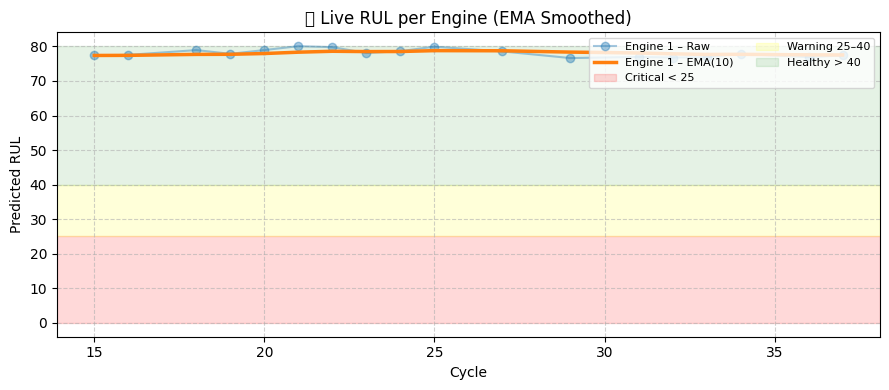

🛑 Live EMA plot stopped after 2 minutes – final snapshot shown above.


In [ ]:
# ============================================================
# │ Step 9 (Enhanced): Multi-Engine Live RUL Visualization + EMA Trend
# ============================================================

import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import pandas as pd
import time

# live_predictions must be populated by Step 8:
# live_predictions.append((engine_id, cycle, pred_rul))

def plot_live_rul_multi_ema(live_predictions, window=150, ema_span=10):
    """Plot live RUL per engine with exponential moving average smoothing."""
    if not live_predictions:
        return

    df = pd.DataFrame(live_predictions, columns=["Engine", "Cycle", "Predicted RUL"])
    df_tail = df.tail(window)

    clear_output(wait=True)
    plt.figure(figsize=(9, 4))

    # Plot each engine and its EMA trend
    for eng_id, sub_df in df_tail.groupby("Engine"):
        plt.plot(
            sub_df["Cycle"],
            sub_df["Predicted RUL"],
            marker="o",
            linewidth=1.5,
            alpha=0.4,
            label=f"Engine {int(eng_id)} – Raw"
        )
        ema = sub_df["Predicted RUL"].ewm(span=ema_span, adjust=False).mean()
        plt.plot(
            sub_df["Cycle"],
            ema,
            linewidth=2.5,
            label=f"Engine {int(eng_id)} – EMA({ema_span})"
        )

    # Alert zones
    plt.axhspan(0, 25, color="red", alpha=0.15, label="Critical < 25")
    plt.axhspan(25, 40, color="yellow", alpha=0.15, label="Warning 25–40")
    plt.axhspan(40, max(df_tail["Predicted RUL"].max(), 50),
                color="green", alpha=0.1, label="Healthy > 40")

    plt.title("🧩 Live RUL per Engine (EMA Smoothed)")
    plt.xlabel("Cycle")
    plt.ylabel("Predicted RUL")
    plt.legend(loc="upper right", ncol=2, fontsize=8)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

# --- Auto-run for 2 minutes, refresh every 2 seconds ---
duration = 120
start_time = time.time()
print("📊 Multi-Engine RUL EMA plot updating every 2 seconds for 2 minutes...")
while time.time() - start_time < duration:
    plot_live_rul_multi_ema(live_predictions)
    time.sleep(2)

# Final snapshot
plot_live_rul_multi_ema(live_predictions)
print("🛑 Live EMA plot stopped after 2 minutes – final snapshot shown above.")


In [ ]:
import json

def trigger_local_dashboard(rul, engine_id, cycle):
    payload = {
        "engine_id": engine_id,
        "cycle": cycle,
        "predicted_RUL": rul,
        "status": "ALERT" if rul < 40 else "OK",
        "time": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    with open("dashboard.json", "w") as f:
        json.dump(payload, f, indent=2)
    print(json.dumps(payload, indent=2))


In [ ]:
import json, time, os

print("📊 Watching dashboard.json for live alerts (Ctrl+C to stop)")
try:
    while True:
        if os.path.exists("dashboard.json"):
            with open("dashboard.json") as f:
                data = json.load(f)
            clear_output(wait=True)
            print(json.dumps(data, indent=2))
        time.sleep(3)
except KeyboardInterrupt:
    print("🛑 Live dashboard watch stopped.")


📊 Watching dashboard.json for live alerts (Ctrl+C to stop)
🛑 Live dashboard watch stopped.


In [ ]:
!pip install streamlit -q
!curl -fsSL https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -o cloudflared
!chmod +x cloudflared





In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import time
import os

st.set_page_config(page_title="Predictive Maintenance Dashboard", layout="wide")
st.title("🧠 Predictive Maintenance Dashboard")

st.markdown("Displays latest **Remaining Useful Life (RUL)** predictions and health zones.")

# --- Load or mock data ---
csv_path = "live_predictions.csv"
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    # demo data
    df = pd.DataFrame({
        "Engine": [1, 2, 3],
        "Cycle": [120, 850, 480],
        "Predicted RUL": [33.4, 37.9, 25.1]
    })

# --- Display Table ---
st.subheader("📊 Latest Predictions")
st.dataframe(df.tail(10), use_container_width=True)

# --- Status Cards ---
col1, col2, col3 = st.columns(3)
for i, row in df.tail(3).iterrows():
    color = "🟩 Healthy" if row["Predicted RUL"] > 40 else ("🟨 Warning" if row["Predicted RUL"] > 25 else "🟥 Critical")
    with [col1, col2, col3][i % 3]:
        st.metric(label=f"Engine {int(row['Engine'])} (Cycle {int(row['Cycle'])})",
                  value=f"{row['Predicted RUL']:.1f}",
                  delta=color)

# --- Trend Chart ---
if "Cycle" in df.columns:
    st.subheader("📈 RUL Trend (Recent Cycles)")
    st.line_chart(df.set_index("Cycle")[["Predicted RUL"]])

# --- Auto-refresh every 10 s ---
st.markdown("<hr>", unsafe_allow_html=True)
st.caption("Auto-refreshing every 10 seconds — press ‘R’ to reload manually.")
time.sleep(10)
st.experimental_rerun()


Overwriting app.py


In [ ]:
!streamlit run app.py --server.port 8501 &>/content/logs.txt &
!./cloudflared tunnel --url http://localhost:8501


2025-11-06T12:14:01Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-11-06T12:14:01Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-11-06T12:14:05Z INF +--------------------------------------------------------------------------------------------+
2025-11-06T12:14:05Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-11-06T12:14:05Z INF |  https://mazda-subcommittee-gates-convinced.trycloudfl

In [ ]:
!npx localtunnel --port 8501 --subdomain rul-demo


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸your url is: https://rul-demo.loca.lt
^C
